<a href="https://colab.research.google.com/github/skreddypalvai/PE9nyrOMEtPAhrwc/blob/main/cnn_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.src.utils.tf_utils import set_random_seed
#reproducebility
set_random_seed(42)

In [ ]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Input, TimeDistributed, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

In [ ]:
# Define constants
train_data_dir = '/content/drive/MyDrive/images/training'
test_data_dir = '/content/drive/MyDrive/images/testing'
sequence_length = 3
img_width, img_height = 128, 128
channels = 3

In [ ]:
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    img = img.astype('float32') / 255.0  # Normalize pixel values
    return img

# 1. Data Preprocessing
def preprocess_data(data_dir):
    sequences = []
    labels = []

    for subdir in os.listdir(data_dir):
        subpath = os.path.join(data_dir, subdir)
        if os.path.isdir(subpath):
            images = sorted([f for f in os.listdir(subpath) if f.endswith('.jpg')])
            for i in range(0, len(images) - sequence_length + 1, sequence_length):
                sequence = []
                for j in range(i, i + sequence_length):
                    image_path = os.path.join(subpath, images[j])
                    img = load_and_preprocess_image(image_path)
                    sequence.append(img)
                sequences.append(sequence)

                # Labeling based on subfolder
                label = 1 if subdir == 'flip' else 0
                labels.append(label)
    return np.array(sequences), np.array(labels)

In [ ]:
X_train, y_train = preprocess_data(train_data_dir)
X_test, y_test = preprocess_data(test_data_dir)

In [ ]:
train_classes = np.unique(y_train)
test_classes = np.unique(y_test)
print("Classes in y_train:", train_classes)
print("Classes in y_test:", test_classes)

Classes in y_train: [0 1]
Classes in y_test: [0 1]


In [ ]:
print(f'Training Sequences shape: {X_train.shape}')
print(f'Training Labels shape: {y_train.shape}')
print(f'Test Sequences shape: {X_test.shape}')
print(f'Test Labels shape: {y_test.shape}')

Training Sequences shape: (797, 3, 128, 128, 3)
Training Labels shape: (797,)
Test Sequences shape: (198, 3, 128, 128, 3)
Test Labels shape: (198,)


In [ ]:
!rm -rf ./logs/

In [ ]:
import tensorflow.keras.backend as K
K.clear_session()

In [ ]:

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, channels)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten()
])
rnn_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, cnn_model.output_shape[-1])),
    LSTM(64)
])
model = Sequential([
    TimeDistributed(cnn_model, input_shape=(sequence_length, img_width, img_height, channels)),
    TimeDistributed(Flatten()),
    rnn_model,
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 3, 4608)           240832    
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 3, 4608)           0         
 stributed)                                                      
                                                                 
 sequential_1 (Sequential)   (None, 64)                1229312   
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1470209 (5.61 MB)
Trainable params: 1470209 (5.61 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Training the model
training = model.fit(X_train, y_train, epochs=14,validation_data=[X_test,y_test], batch_size=32)

Epoch 1/14
25/25 [==============================] - 102s 4s/step - loss: 0.6931 - accuracy: 0.5094 - val_loss: 0.6854 - val_accuracy: 0.5152
Epoch 2/14
25/25 [==============================] - 96s 4s/step - loss: 0.6703 - accuracy: 0.5834 - val_loss: 0.6636 - val_accuracy: 0.6263
Epoch 3/14
25/25 [==============================] - 91s 4s/step - loss: 0.6275 - accuracy: 0.6236 - val_loss: 0.6269 - val_accuracy: 0.6667
Epoch 4/14
25/25 [==============================] - 102s 4s/step - loss: 0.4804 - accuracy: 0.7654 - val_loss: 0.4011 - val_accuracy: 0.8081
Epoch 5/14
25/25 [==============================] - 94s 4s/step - loss: 0.2894 - accuracy: 0.8733 - val_loss: 0.3693 - val_accuracy: 0.8586
Epoch 6/14
25/25 [==============================] - 96s 4s/step - loss: 0.3310 - accuracy: 0.8683 - val_loss: 0.1949 - val_accuracy: 0.9495
Epoch 7/14
25/25 [==============================] - 97s 4s/step - loss: 0.1647 - accuracy: 0.9410 - val_loss: 0.1160 - val_accuracy: 0.9646
Epoch 8/14
25/25 [

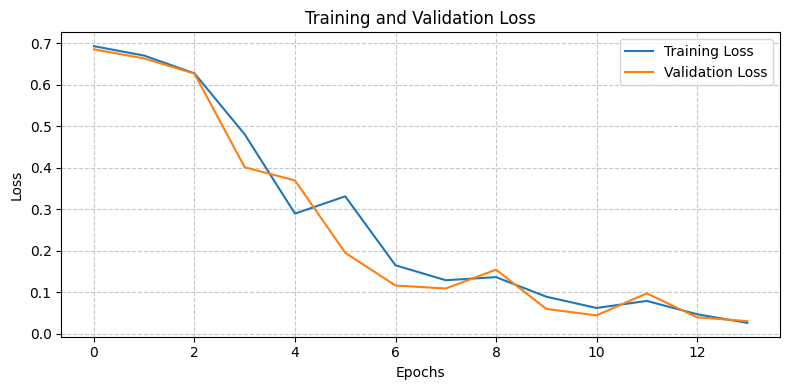

In [ ]:
train_loss = training.history['loss']
val_loss = training.history['val_loss']
fig, ax1 = plt.subplots(figsize=(8, 4))
# Plot training and validation loss
ax1.plot(train_loss, label='Training Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()
plt.tight_layout()
plt.show()

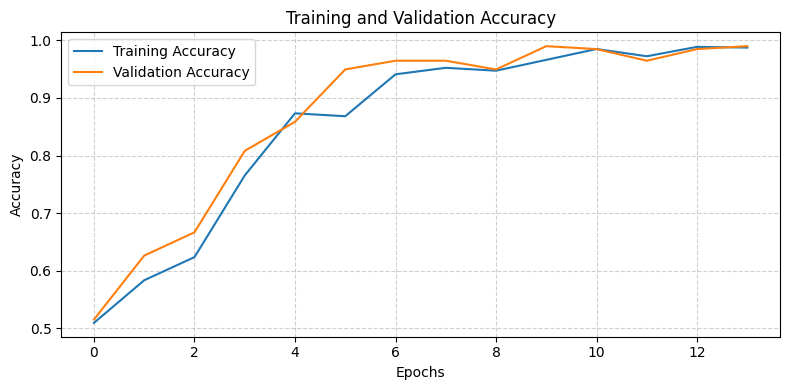

In [ ]:
train_accuracy = training.history['accuracy']
val_accuracy = training.history['val_accuracy']
#monitoring train and val accuracy
fig, ax2 = plt.subplots(figsize=(8, 4))
ax2.plot(train_accuracy, label='Training Accuracy')
ax2.plot(val_accuracy, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend()
plt.tight_layout()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
report = classification_report(y_test, y_pred)
print(report)

7/7 [==============================] - 11s 1s/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       102
           1       0.99      0.99      0.99        96

    accuracy                           0.99       198
   macro avg       0.99      0.99      0.99       198
weighted avg       0.99      0.99      0.99       198



1/1 [==============================] - 0s 52ms/step


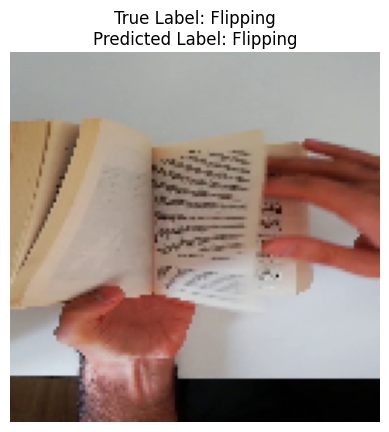

In [ ]:
random_index = random.randint(0, len(X_test) - 1)
random_image = X_test[random_index]
true_label = y_test[random_index]
random_image = random_image.reshape(1, sequence_length, img_width, img_height, channels)
predicted_label = model.predict(random_image)
predicted_label = (predicted_label > 0.5).astype(int)
plt.imshow(random_image[0][0])
plt.title(f"True Label: {'Flipping' if true_label == 1 else 'Not Flipping'}\nPredicted Label: {'Flipping' if predicted_label == 1 else 'Not Flipping'}")
plt.axis('off')
plt.show()